In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
data_dir

WindowsPath('C:/Users/user/.keras/datasets/flower_photos')

### 케라스 유틸리티로 데이터 로드
- 사용자가 설정한 배치크기만큼 데이터셋을 가져온다, 3000개를 다 가져올 필요가 없으니까
- 이미지 크기를 지정한 사이즈로 통일하고
- x 데이터를 세트로 어레이 시키고
- y 값은 폴더이름에 따라서 순차적으로 부여됨
- 폴더이름을 칼럼 class_name에 할당
- x,y 트레인, 테스트 데이터를 나누기도 함


In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, # 훈련 데이터 검증용
  subset="training", 
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [7]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


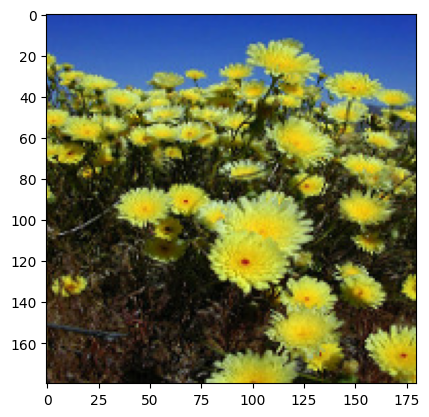

In [9]:
img = list(train_ds)[0][0][1].numpy().astype('uint8')
plt.imshow(img)

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [26]:
num_classes = len(class_names)

model = Sequential([
    # 모델만 돌리면 알아서 255로 나눠줌.
    # 디렉토리에서 쓰는 데이터는 1./255 사용하기
    # 넘파이 자료는 스케일링이 되어 있을 수도 있다
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(), # 2x2 s2
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [27]:
model.compile(loss="sparse_categorical_crossentropy",  
              optimizer='adam',
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [29]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 18s 184ms/step - loss: 1.4693 - accuracy: 0.3627 - val_loss: 1.2303 - val_accuracy: 0.5191
Epoch 2/10
92/92 [==============================] - 17s 189ms/step - loss: 1.0740 - accuracy: 0.5593 - val_loss: 1.0660 - val_accuracy: 0.5450
Epoch 3/10
92/92 [==============================] - 19s 203ms/step - loss: 0.9753 - accuracy: 0.6131 - val_loss: 0.9526 - val_accuracy: 0.6267
Epoch 4/10
92/92 [==============================] - 21s 229ms/step - loss: 0.9034 - accuracy: 0.6505 - val_loss: 0.8868 - val_accuracy: 0.6444
Epoch 5/10
92/92 [==============================] - 21s 228ms/step - loss: 0.8611 - accuracy: 0.6614 - val_loss: 0.9480 - val_accuracy: 0.6431
Epoch 6/10
92/92 [==============================] - 21s 227ms/step - loss: 0.8073 - accuracy: 0.6887 - val_loss: 0.8419 - val_accuracy: 0.6594
Epoch 7/10
92/92 [==============================] - 21s 226ms/step - loss: 0.7685 - accuracy: 0.7037 - val_loss: 0.7952 - val_accuracy: 0.6935

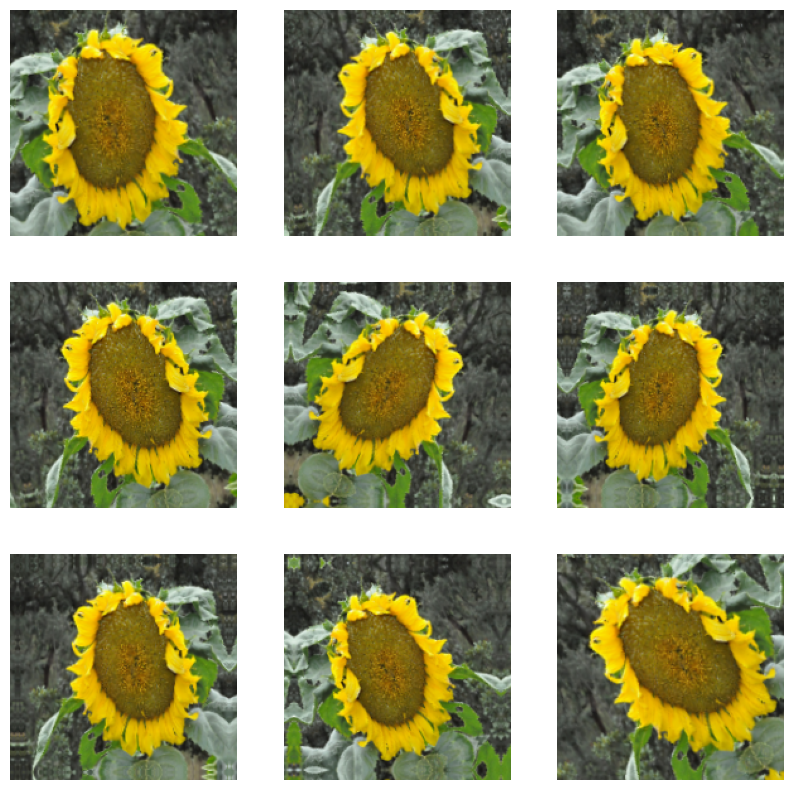

In [30]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

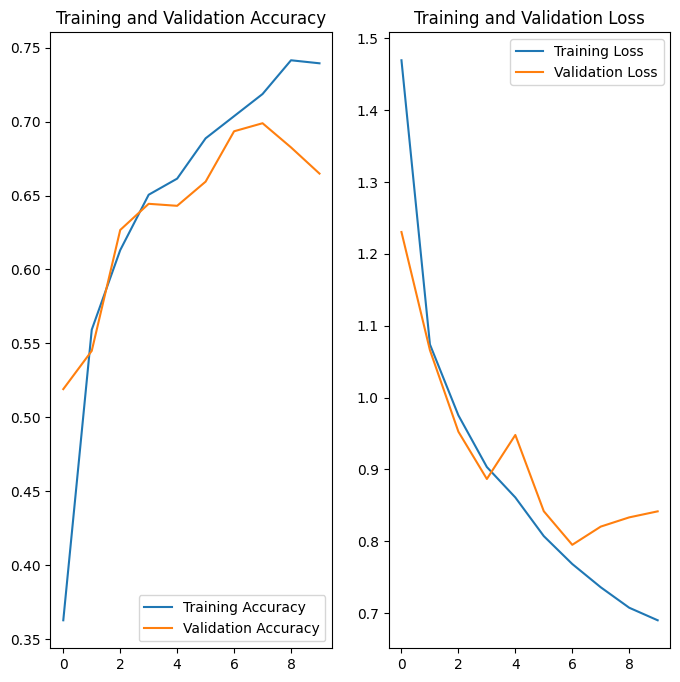

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- 자료 세이브
- 분류 리포트

In [32]:
model.save('saved_model/my_model.h5')